# BigEarthNet - Application to downstream tasks

In [49]:
import torch
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import hamming_loss, multilabel_confusion_matrix, fbeta_score
from convert_labels import convert_labels
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import math
import seaborn as sns

In [50]:
train_feat = torch.load('./features/feat-train-bigearthnet.pth')
train_labels = torch.load('./features/labels-train-bigearthnet.pth')
test_feat = torch.load('./features/feat-test-bigearthnet.pth')
test_labels = torch.load('./features/labels-test-bigearthnet.pth')

flattened_train_features = np.array(train_feat.view(-1, 768))
flattened_train_labels = np.array(train_labels.view(-1, 43))
flattened_train_labels = convert_labels(flattened_train_labels)
flattened_test_features = np.array(test_feat.view(-1, 768))
flattened_test_labels = np.array(test_labels.view(-1, 43))
flattened_test_labels = convert_labels(flattened_test_labels)

In [51]:
print(flattened_train_features.shape)
print(flattened_train_labels.shape)
print(flattened_test_features.shape)
print(flattened_test_labels.shape)

(269696, 768)
(269696, 19)
(125888, 768)
(125888, 19)


In [52]:
train_count = flattened_train_features.shape[0]
test_count = flattened_test_features.shape[0]

In [53]:
# retrieved from https://git.tu-berlin.de/rsim/BigEarthNet-MM_19-classes_models/-/blob/master/label_indices.json?ref_type=heads
class_names = [
        "Urban fabric",
        "Industrial or commercial units",
        "Arable land",
        "Permanent crops",
        "Pastures",
        "Complex cultivation patterns",
        "Agriculture with a lot of natural vegetation", # shortened from "Land principally occupied by agriculture, with significant areas of natural vegetation",
        "Agro-forestry areas",
        "Broad-leaved forest",
        "Coniferous forest",
        "Mixed forest",
        "Natural grassland (sparsely vegetated)", # shortened from "Natural grassland and sparsely vegetated areas",
        "Moors, heathland", # shortened from "Moors, heathland and sclerophyllous vegetation",
        "Transitional woodland, shrub",
        "Beaches, dunes, sands",
        "Inland wetlands",
        "Coastal wetlands",
        "Inland waters",
        "Marine waters",
]

In [71]:
def plotMulticlassConfusionMatrix(title, cm, class_names):
    columns = 5
    fig, axs = plt.subplots(math.ceil(len(class_names) / columns), columns, figsize=(20, 20))
    for i, cl_name in enumerate(class_names):
        ax = axs[i // columns][i % columns]
        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        group_counts = ["{0:0.0f}".format(value) for value in cm[i].flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm[i].flatten()/np.sum(cm[i])]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cm[i], annot=labels, fmt="", cmap='Blues', ax=ax, cbar=False, xticklabels=False, yticklabels=False)
        ax.set_title(cl_name)
    axs[-1, -1].axis('off')
    plt.suptitle("Confusion Matrices - " + title, size=16, y=0.92)
    plt.savefig("images/" + title + " - confusion matrix.png")
    plt.show()

def plotMulticlassF2Scores(title, cm, class_names):
    f2_scores = []
    for i, cl_name in enumerate(class_names):
        tp = cm[i][1][1]
        fp = cm[i][0][1]
        fn = cm[i][1][0]
        f2 = (5 * tp) / (5 * tp + 4 * fn + fp)
        f2_scores.append(f2)
    f2_scores, class_names = zip(*sorted(zip(f2_scores, class_names)))
    
    plt.bar(class_names, f2_scores)
    plt.xticks(rotation=90)
    plt.title("F2-Scores - " + title, size=16)
    plt.savefig("images/" + title + " - f2 scores.png")
    plt.show()

In [55]:
results = {}

## Random Forest

In [56]:
rf_classifier = RandomForestClassifier(
                        n_estimators=20, 
                        criterion='gini', 
                        random_state=42, 
                        max_depth=None,
                        min_samples_split=10,
                        min_samples_leaf=10,
                        max_features='sqrt',
                        max_leaf_nodes=20000,
                        bootstrap=False,
                        n_jobs=-1)
rf_classifier.fit(flattened_train_features[:train_count], flattened_train_labels[:train_count])

RandomForestClassifier(bootstrap=False, max_leaf_nodes=20000,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=20, n_jobs=-1, random_state=42)

In [57]:
test_preds = rf_classifier.predict(flattened_test_features[:test_count])

In [58]:
flattened_test_labels[:test_count].shape

(125888, 19)

Random Forest Result
f2_macro:  0.21418592679758147
f2_micro:  0.35872432913493285
hamming_loss:  0.12245011438739196
Classification Report
                                              precision    recall  f1-score   support

                                Urban fabric       0.75      0.12      0.21     17925
              Industrial or commercial units       0.74      0.06      0.11      2808
                                 Arable land       0.71      0.57      0.63     47147
                             Permanent crops       0.00      0.00      0.00      6812
                                    Pastures       0.65      0.06      0.11     24168
                Complex cultivation patterns       0.50      0.02      0.04     25636
Agriculture with a lot of natural vegetation       0.51      0.05      0.09     32051
                         Agro-forestry areas       0.55      0.10      0.16      7260
                         Broad-leaved forest       0.65      0.19      0.29     34129

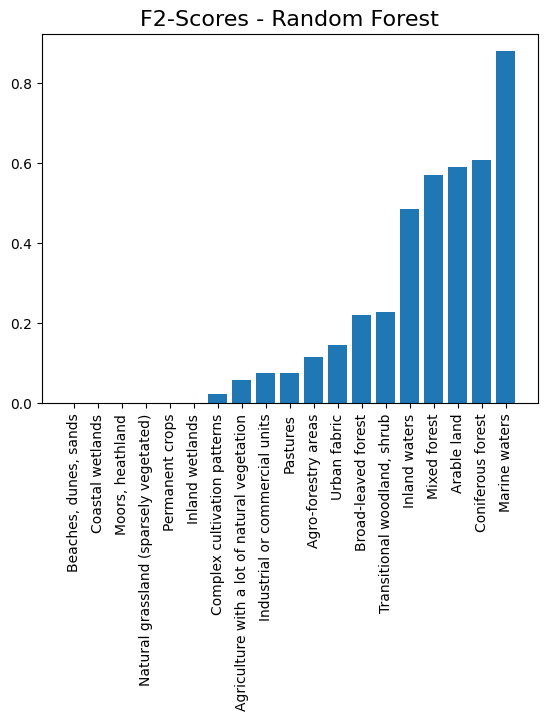

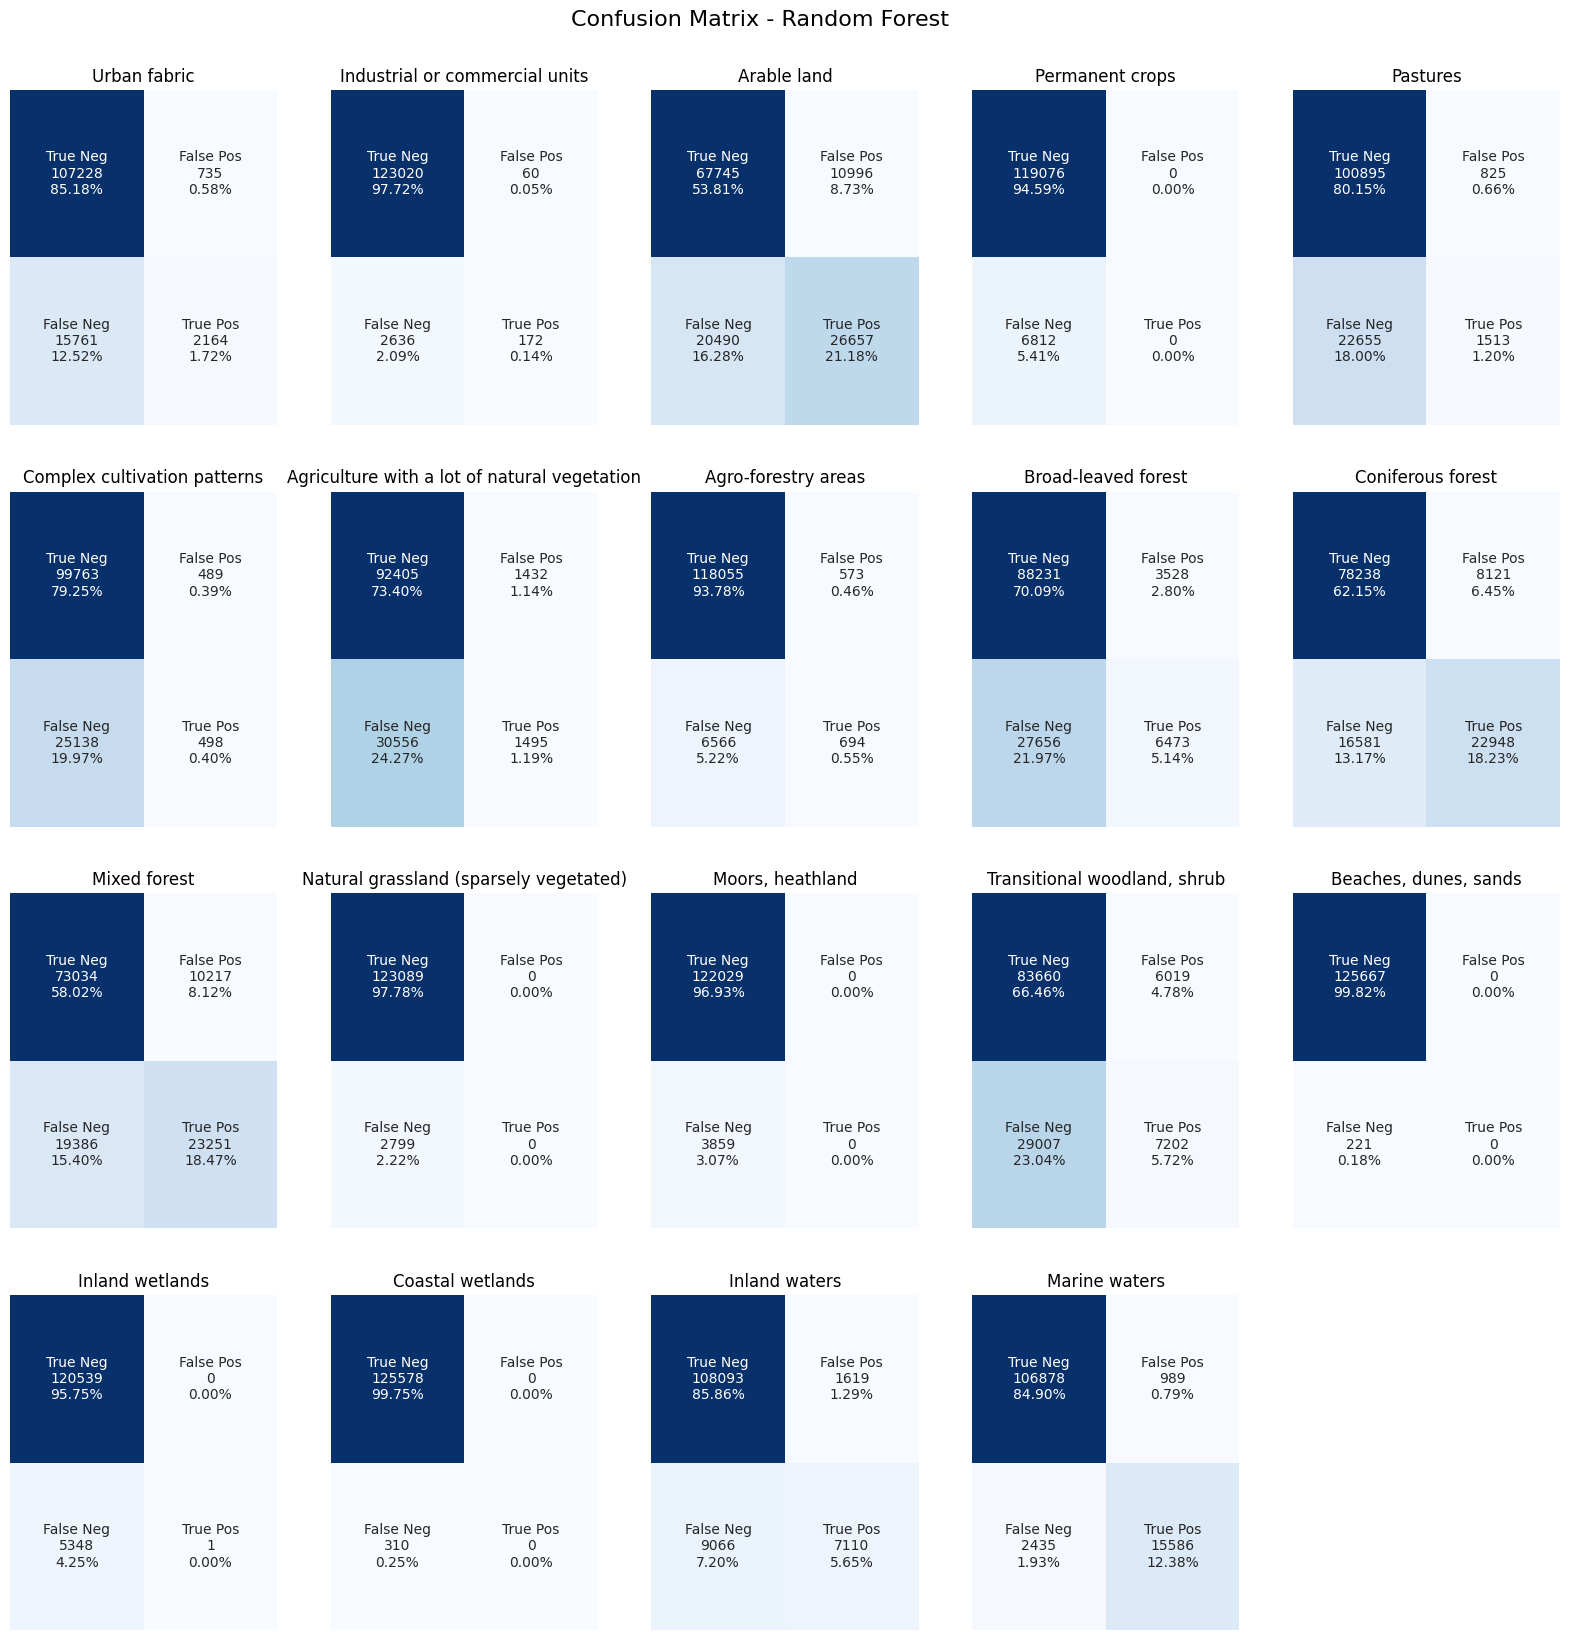

In [59]:
print("Random Forest Result")
fbeta_macro = fbeta_score(flattened_test_labels[:test_count], test_preds, average='macro', beta=2)
fbeta_micro = fbeta_score(flattened_test_labels[:test_count], test_preds, average='micro', beta=2)
hamming_loss_score = hamming_loss(flattened_test_labels[:test_count], test_preds)
results["Random Forest"] = {
    "f2_macro": fbeta_macro,
    "f2_micro": fbeta_micro,
    "hamming_loss": hamming_loss_score
}
print("f2_macro: ", fbeta_macro)
print("f2_micro: ", fbeta_micro)
print("hamming_loss: ", hamming_loss_score)
print("Classification Report")
print(classification_report(flattened_test_labels[:test_count], test_preds, target_names=class_names, zero_division=0))

cm = multilabel_confusion_matrix(flattened_test_labels[:test_count], test_preds)
plotMulticlassF2Scores("Random Forest", cm, class_names)
plotMulticlassConfusionMatrix("Random Forest", cm, class_names)

Comparison to paper:
- f2_macro: about 0.48
- f2_micro: about 0.68
- hamming loss: 4.0 ???

## Linear Probing

In [60]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device: ", device)

device:  mps


In [61]:
torch.manual_seed(0)
scaler = StandardScaler()
X_train = scaler.fit_transform(flattened_train_features)
X_test = scaler.transform(flattened_test_features)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(flattened_train_labels, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(flattened_test_labels, dtype=torch.float32).to(device)

In [62]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

In [63]:
class LinearLayer(nn.Module):
    def __init__(self):
        super(LinearLayer, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(768, 19),
        )

    def forward(self, x):
        return self.layers(x)

model = LinearLayer().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [64]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for data, targets in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 1, Loss: 0.3106
Epoch 2, Loss: 0.3037
Epoch 3, Loss: 0.2779
Epoch 4, Loss: 0.3183
Epoch 5, Loss: 0.2558
Epoch 6, Loss: 0.2903
Epoch 7, Loss: 0.2807
Epoch 8, Loss: 0.2766
Epoch 9, Loss: 0.2934
Epoch 10, Loss: 0.3057
Epoch 11, Loss: 0.2800
Epoch 12, Loss: 0.2738
Epoch 13, Loss: 0.2972
Epoch 14, Loss: 0.2681
Epoch 15, Loss: 0.3114
Epoch 16, Loss: 0.3271
Epoch 17, Loss: 0.2897
Epoch 18, Loss: 0.2994
Epoch 19, Loss: 0.2713
Epoch 20, Loss: 0.2951


In [65]:
model.eval()
test_preds = model(X_test) > 0
test_preds = test_preds.cpu().detach().numpy()

Linear Probing result
f2_macro:  0.2288514985275511
f2_micro:  0.35291425584712116
hamming_loss:  0.12445523840740641
Classification Report
                                              precision    recall  f1-score   support

                                Urban fabric       0.74      0.23      0.35     17925
              Industrial or commercial units       0.56      0.24      0.34      2808
                                 Arable land       0.69      0.59      0.64     47147
                             Permanent crops       0.17      0.00      0.00      6812
                                    Pastures       0.57      0.07      0.13     24168
                Complex cultivation patterns       0.49      0.06      0.10     25636
Agriculture with a lot of natural vegetation       0.41      0.05      0.10     32051
                         Agro-forestry areas       0.55      0.16      0.24      7260
                         Broad-leaved forest       0.65      0.17      0.27     34129

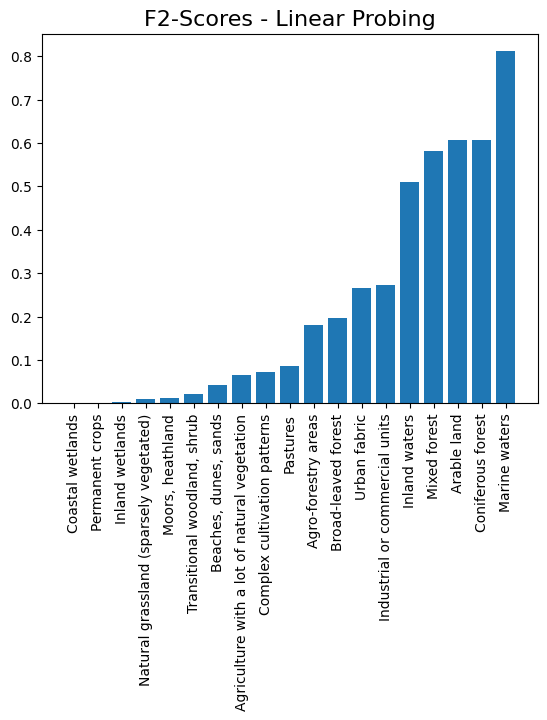

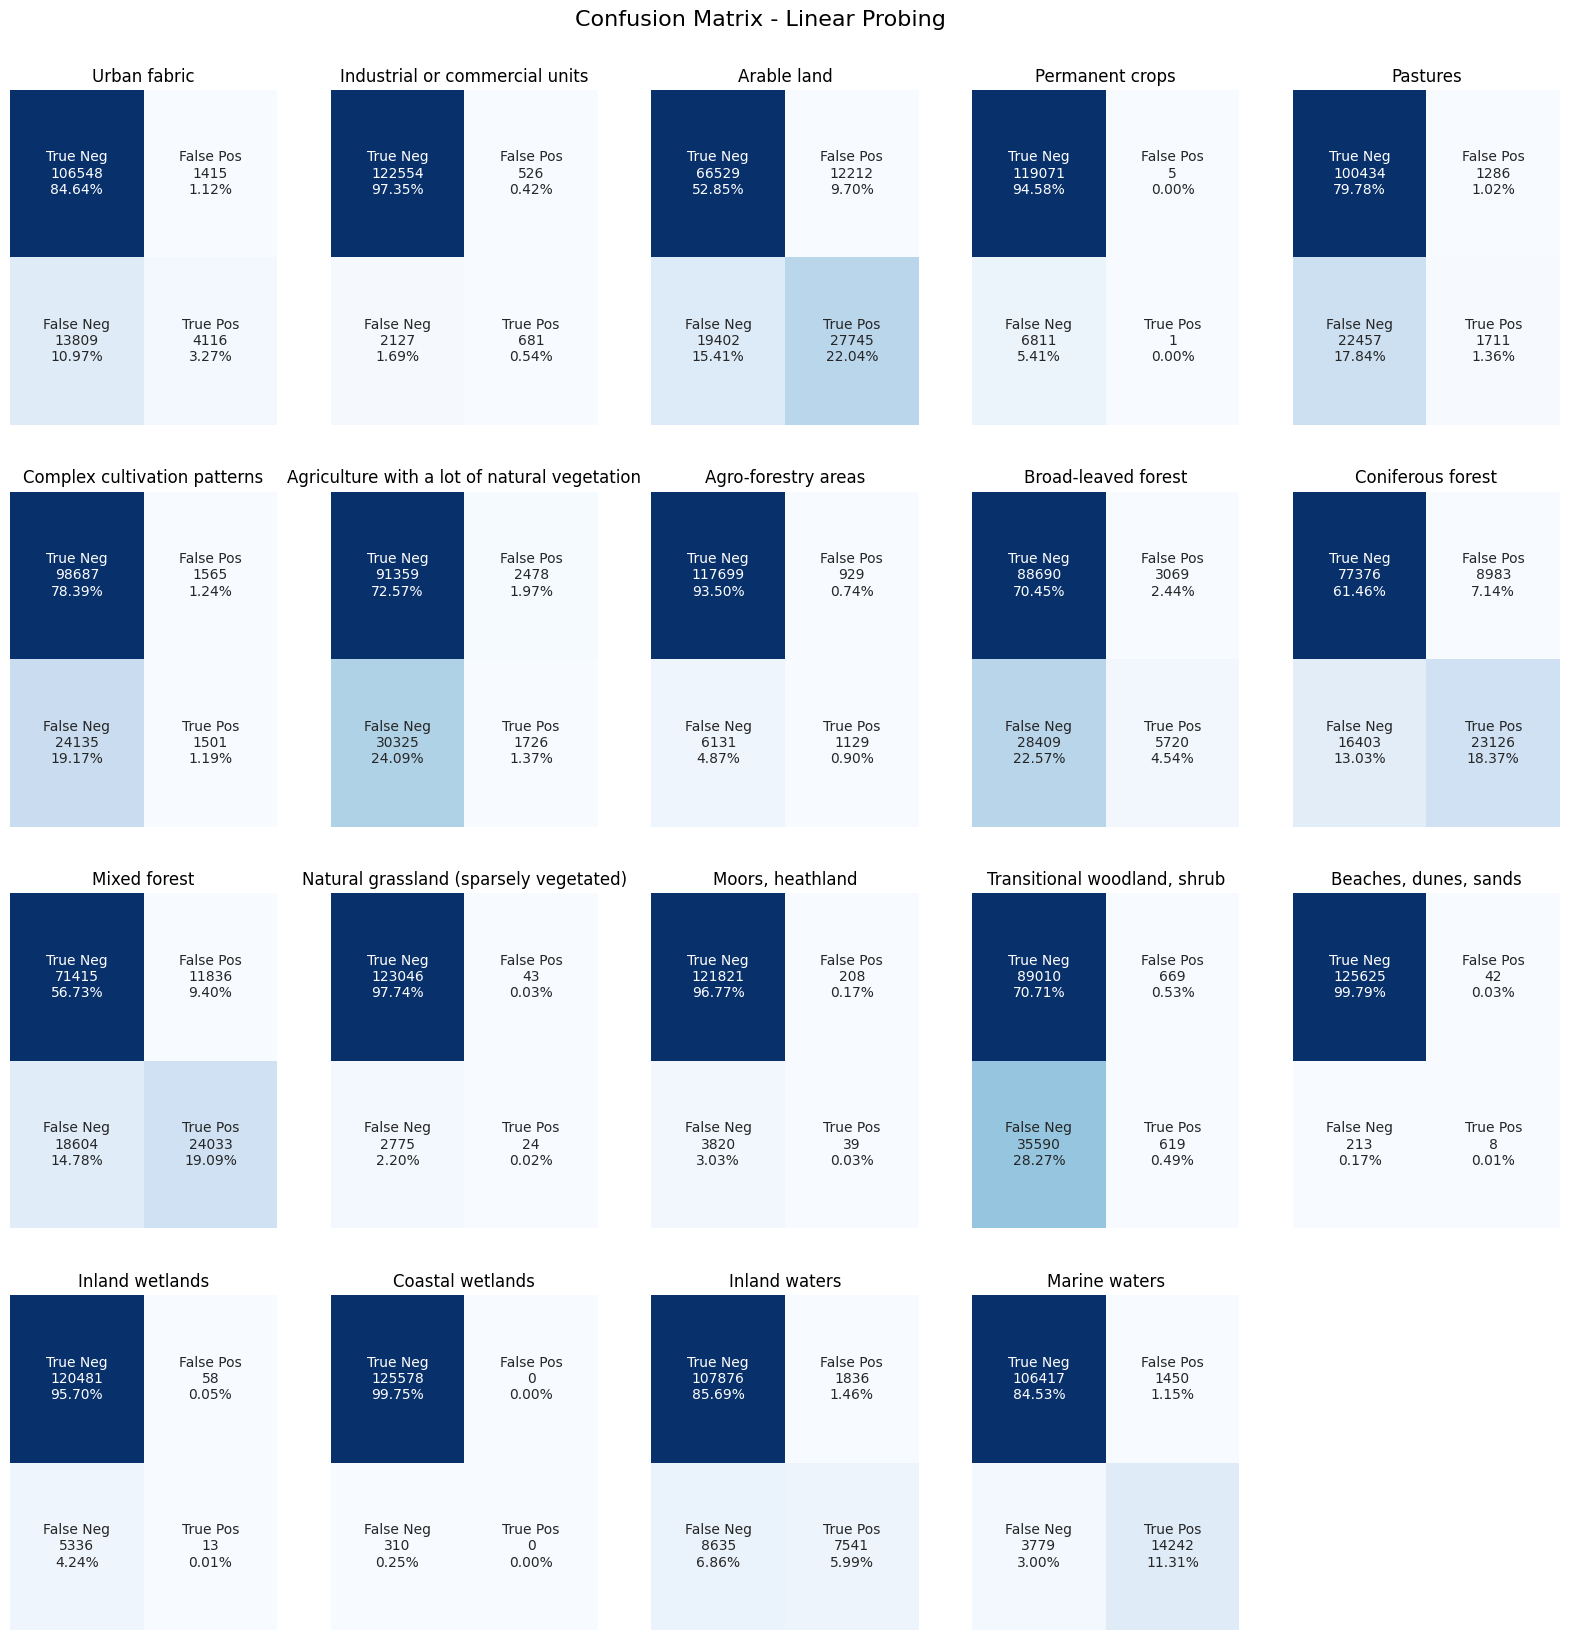

In [66]:
print("Linear Probing result")
fbeta_macro = fbeta_score(flattened_test_labels[:test_count], test_preds, average='macro', beta=2)
fbeta_micro = fbeta_score(flattened_test_labels[:test_count], test_preds, average='micro', beta=2)
hamming_loss_score = hamming_loss(flattened_test_labels[:test_count], test_preds)
results["Linear Probing"] = {
    "f2_macro": fbeta_macro,
    "f2_micro": fbeta_micro,
    "hamming_loss": hamming_loss_score
}
print("f2_macro: ", fbeta_macro)
print("f2_micro: ", fbeta_micro)
print("hamming_loss: ", hamming_loss_score)
print("Classification Report")
print(classification_report(flattened_test_labels[:test_count], test_preds, target_names=class_names, zero_division=0))

cm = multilabel_confusion_matrix(flattened_test_labels[:test_count], test_preds)
plotMulticlassF2Scores("Linear Probing", cm, class_names)
plotMulticlassConfusionMatrix("Linear Probing", cm, class_names)

Comparison to paper:
- f2_macro: about 0.48
- f2_micro: about 0.68
- hamming loss: 4.0 ???
  
## Multi Layer Perceptron

In [67]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(768, 384),
            nn.ReLU(),
            nn.Linear(384, 192),
            nn.ReLU(),
            nn.Linear(192, 100),
            nn.ReLU(),
            nn.Linear(100, 19)
        )

    def forward(self, x):
        return self.layers(x)

model = MLP().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [68]:
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for data, targets in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 1, Loss: 0.2528
Epoch 2, Loss: 0.2536
Epoch 3, Loss: 0.2677
Epoch 4, Loss: 0.2273
Epoch 5, Loss: 0.2719
Epoch 6, Loss: 0.2863
Epoch 7, Loss: 0.2522
Epoch 8, Loss: 0.2451
Epoch 9, Loss: 0.2755
Epoch 10, Loss: 0.2272
Epoch 11, Loss: 0.2474
Epoch 12, Loss: 0.2952
Epoch 13, Loss: 0.2530
Epoch 14, Loss: 0.2362
Epoch 15, Loss: 0.2443
Epoch 16, Loss: 0.2427
Epoch 17, Loss: 0.2530
Epoch 18, Loss: 0.2408
Epoch 19, Loss: 0.2337
Epoch 20, Loss: 0.2555


MLP result
f2_macro:  0.3446619676702712
f2_micro:  0.4777504054256791
hamming_loss:  0.11270837235437348
Classification Report
                                              precision    recall  f1-score   support

                                Urban fabric       0.71      0.33      0.45     17925
              Industrial or commercial units       0.56      0.23      0.33      2808
                                 Arable land       0.72      0.67      0.70     47147
                             Permanent crops       0.38      0.01      0.01      6812
                                    Pastures       0.64      0.30      0.40     24168
                Complex cultivation patterns       0.57      0.20      0.29     25636
Agriculture with a lot of natural vegetation       0.58      0.19      0.28     32051
                         Agro-forestry areas       0.56      0.37      0.44      7260
                         Broad-leaved forest       0.65      0.35      0.45     34129
           

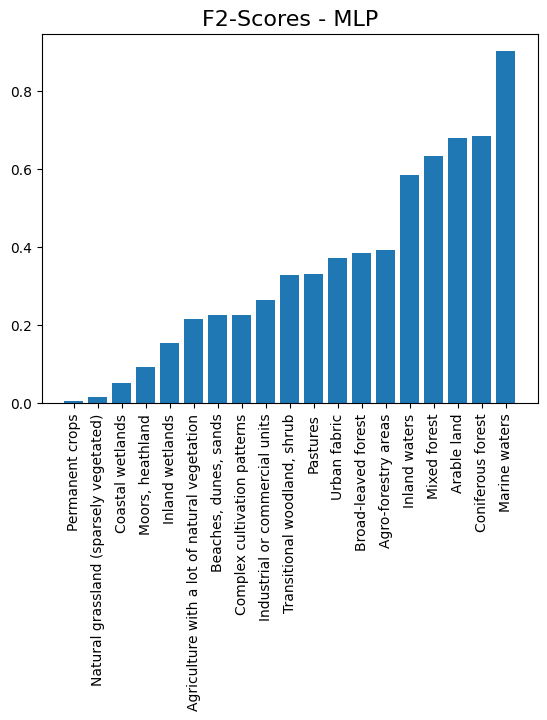

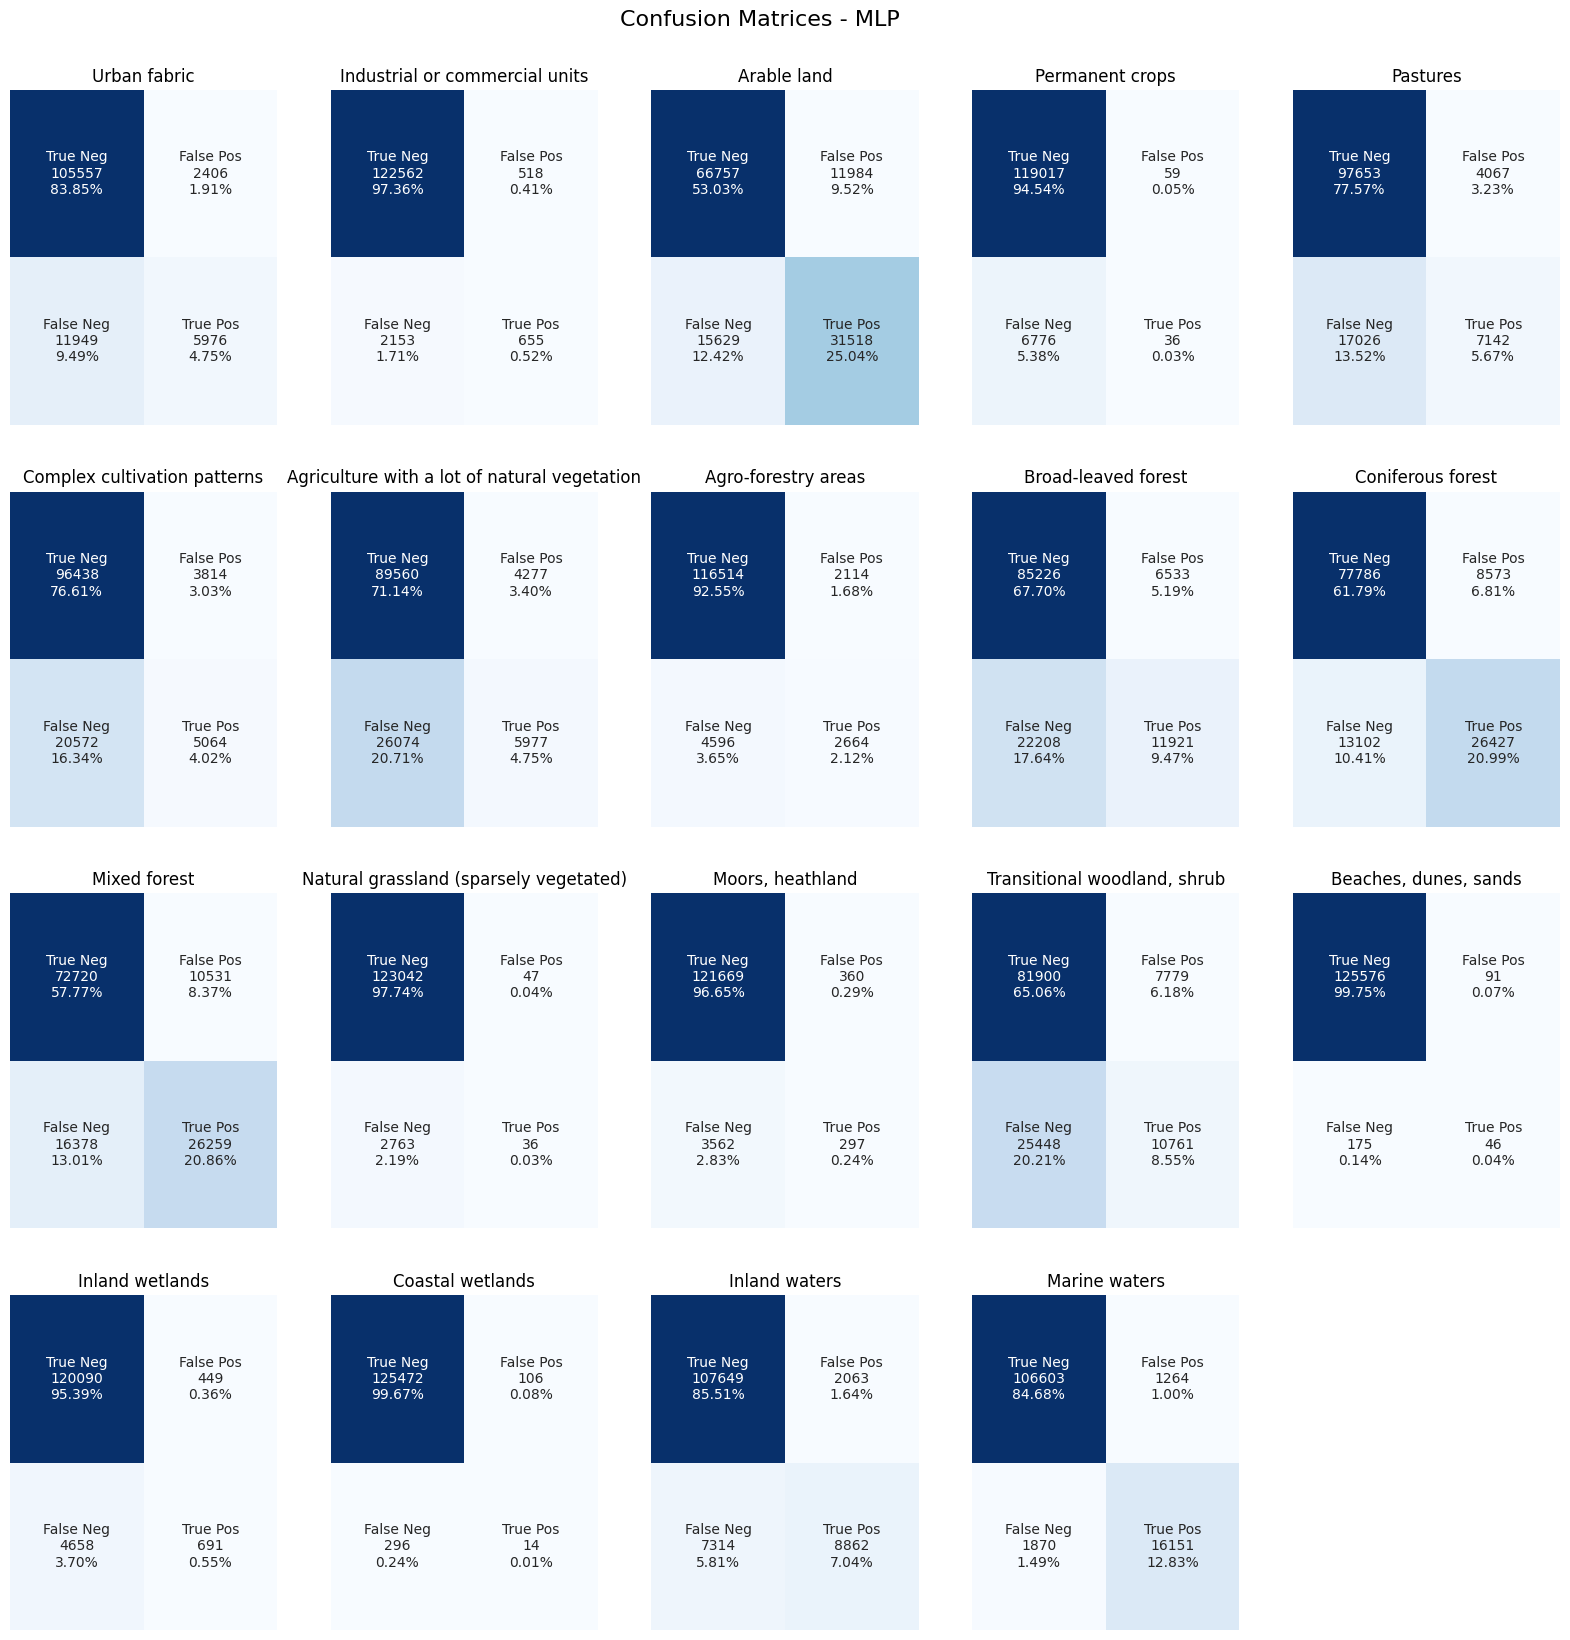

In [72]:
model.eval()
test_preds = model(X_test) > 0
test_preds = test_preds.cpu().detach().numpy()

print("MLP result")
fbeta_macro = fbeta_score(flattened_test_labels[:test_count], test_preds, average='macro', beta=2)
fbeta_micro = fbeta_score(flattened_test_labels[:test_count], test_preds, average='micro', beta=2)
hamming_loss_score = hamming_loss(flattened_test_labels[:test_count], test_preds)
results["MLP"] = {
    "f2_macro": fbeta_macro,
    "f2_micro": fbeta_micro,
    "hamming_loss": hamming_loss_score
}
print("f2_macro: ", fbeta_macro)
print("f2_micro: ", fbeta_micro)
print("hamming_loss: ", hamming_loss_score)
print("Classification Report")
print(classification_report(flattened_test_labels[:test_count], test_preds, target_names=class_names, zero_division=0))

cm = multilabel_confusion_matrix(flattened_test_labels[:test_count], test_preds)
plotMulticlassF2Scores("MLP", cm, class_names)
plotMulticlassConfusionMatrix("MLP", cm, class_names)

Comparison to paper:
- f2_macro: about 0.48
- f2_micro: about 0.68
- hamming loss: 4.0 ???

## Comparison

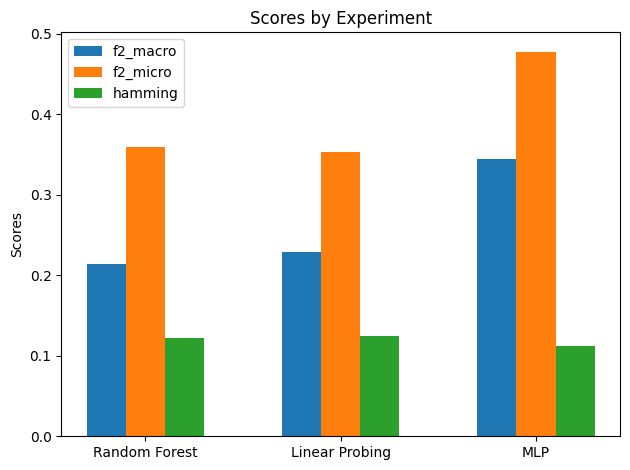

In [73]:
f2_macros = []
f2_micros = []
hamming = []
for key in results:
    f2_macros.append(results[key]["f2_macro"])
    f2_micros.append(results[key]["f2_micro"])
    hamming.append(results[key]["hamming_loss"])

x = np.arange(len(results.keys()))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, f2_macros, width, label='f2_macro')
rects2 = ax.bar(x, f2_micros, width, label='f2_micro')
rects3 = ax.bar(x + width, hamming, width, label='hamming')

ax.set_ylabel('Scores')
ax.set_title('Scores by Experiment')
ax.set_xticks(x)
ax.set_xticklabels(results.keys())
ax.legend()

fig.tight_layout()
plt.title("Scores by Experiment")
plt.savefig("images/scores by experiment.png")
plt.show()